import dataframe found at 

https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/export/?q=charlotte&refine.state=NC

this dataset contains 77 zip codes that are in Charlotte, NC as well as coordinates of their center

# Import Pandas and the dataset

In [1]:
import pandas as pd

df = pd.read_csv('us-zip-code-latitude-and-longitude.csv',delimiter=';')
df.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,28214,Charlotte,NC,35.276639,-80.961110,-5,1,"35.276639, -80.96111"
1,28281,Charlotte,NC,35.260020,-80.804151,-5,1,"35.26002, -80.804151"
2,28210,Charlotte,NC,35.134510,-80.856320,-5,1,"35.13451, -80.85632"
3,28225,Charlotte,NC,35.260020,-80.804151,-5,1,"35.26002, -80.804151"
4,28224,Charlotte,NC,35.260020,-80.804151,-5,1,"35.26002, -80.804151"


# drop unneeded columns

In [2]:
df = df.drop(['City', 'State','Timezone','Daylight savings time flag','geopoint'], axis=1)
df.head()

,Zip,Latitude,Longitude
0,28214,35.276639,-80.961110
1,28281,35.260020,-80.804151
2,28210,35.134510,-80.856320
3,28225,35.260020,-80.804151
4,28224,35.260020,-80.804151


# import other libaries that will be needed

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# get the location of Charlotte, NC

In [4]:
address = 'Charlotte, NC'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Charlotte are {}, {}.'.format(latitude, longitude))

C:\Users\jonvasq\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.19.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Charlotte are 35.2270869, -80.8431268.


# map the zip codes centroids to a map of Charlotte

In [6]:
# create map of Charlotte using latitude and longitude values
map_Charlotte = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, Zip in zip(df['Latitude'], df['Longitude'], df['Zip']):
    label = '{}'.format(Zip)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Charlotte)  

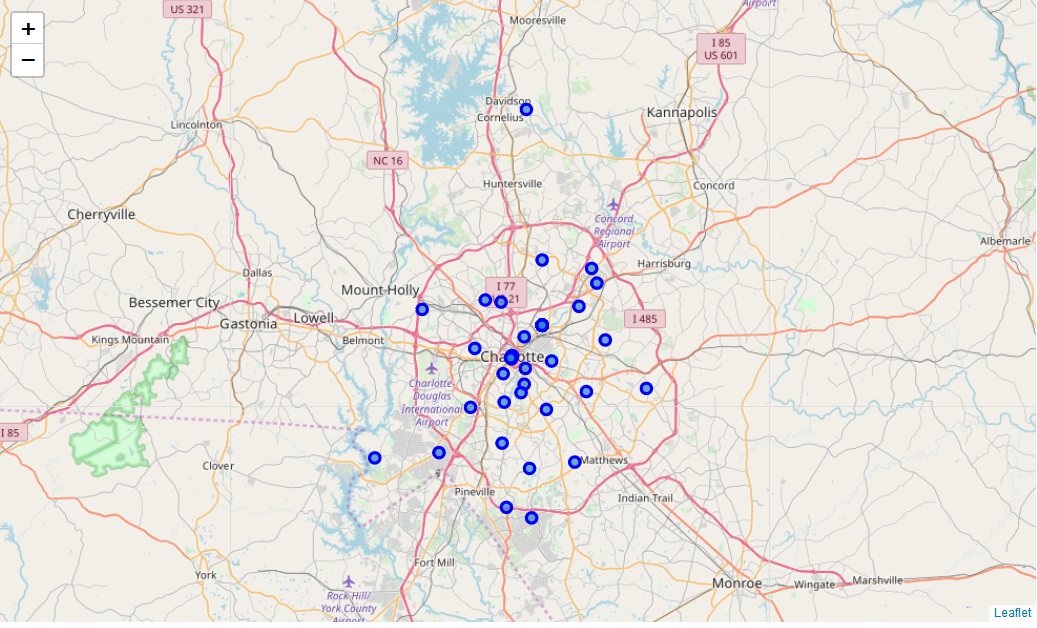

# define credentials

In [7]:
CLIENT_ID = 'ZHBYK5S4NQB44QA3BCAMG2XZAPWQRC0VS1BULPLNBXRH4HGU' # your Foursquare ID
CLIENT_SECRET = '0TWF5104U4L3RDMU1KSVSQNLDK5GXHATXAL1UASWUUZ1CZZL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZHBYK5S4NQB44QA3BCAMG2XZAPWQRC0VS1BULPLNBXRH4HGU
CLIENT_SECRET:0TWF5104U4L3RDMU1KSVSQNLDK5GXHATXAL1UASWUUZ1CZZL


# define category ids 
# found at https://developer.foursquare.com/docs/resources/categories

In [8]:
hospital = '4bf58dd8d48988d196941735'
police_Station = '4bf58dd8d48988d12e941735'
fire_Station = '4bf58dd8d48988d12c941735'
mexican_Restaurant = '4bf58dd8d48988d1c1941735'
italian_Restaurant = '4bf58dd8d48988d110941735'
public_Park = '4bf58dd8d48988d163941735'

catID = hospital+ ',' +police_Station+ ',' +fire_Station+ ',' +mexican_Restaurant+ ',' +italian_Restaurant+ ',' +public_Park

# define code to get venues

In [9]:
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):          
        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?ll="+ str(lat) + "," + str(lng) +"&radius=10000&limit=50&categoryId="+catID+"&client_secret="+ CLIENT_SECRET + "&client_id=" + CLIENT_ID + '&v=20180605'
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append(results)
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name']) for v in results])

    '''nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zip', 
                  'Zip Latitude', 
                  'Zip Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']'''
    
    return(venues_list)

# get venues

In [10]:
Charlotte_venues = getNearbyVenues(names=df['Zip'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

# clean venues to get venue name,category, zipcode,lat,lng

In [12]:
venuelist = []
for i in Charlotte_venues:
    for j in i:
        venuelist.append(j)
venuedetails = []
for i in venuelist:
    try:
        #returns the name of the venue
        name = i['venue']['name']
        #returns the category of the venue
        cat = i['venue']['categories'][0]['name']
        #returns the postal code of the venue
        Zip = i['venue']['location']['postalCode']
        #returns the latitude of the venue
        lat = i['venue']['location']['labeledLatLngs'][0]['lat']
        #returns the longitude of the venue
        lng = i['venue']['location']['labeledLatLngs'][0]['lng']
    except:
        pass
    venuedetails.append([name,cat,Zip,lat,lng])

# convert to dataframe

In [13]:
venuedetails = pd.DataFrame(venuedetails,columns=['name','cat','zip','lat','lng'])
venuedetails.head()

,name,cat,zip,lat,lng
0,Miguel's Restaurant,Mexican Restaurant,28214,35.242033,-80.939744
1,Los Arcos,Mexican Restaurant,28216,35.322849,-80.945166
2,Salsarita's Fresh Cantina,Mexican Restaurant,28208,35.220233,-80.943746
3,Tuckaseege Park,Park,28120,35.280670,-81.014177
4,Vasileios,Italian Restaurant,28120,35.295486,-81.016650


# filter categories to only those we are interested in

In [14]:
cat_list = ['Medical Center','Police Station','Fire Station','Mexican Restaurant','Italian Restaurant','Park']
venuedetails = venuedetails[venuedetails['cat'].isin(cat_list)]
venuedetails = venuedetails.drop_duplicates()
venuedetails['cat'].value_counts()


Mexican Restaurant    186
Park                  146
Italian Restaurant     80
Fire Station           34
Police Station          9
Medical Center          3
Name: cat, dtype: int64

In [18]:
map_venues = folium.Map(location=[latitude, longitude], zoom_start=10)
# add markers to map
for lat, lng, cat in zip(venuedetails['lat'], venuedetails['lng'], venuedetails['cat']):
    label = '{}'.format(cat)
    label = folium.Popup(label, parse_html=True)
    if cat == 'Medical Center':
        color ='blue'
    if cat == 'Police Station':
        color ='orange'
    if cat == 'Fire Station':
        color ='red'
    if cat == 'Mexican Restaurant':
        color ='black'
    if cat == 'Italian Restaurant':
        color='orange'
    if cat == 'Park':
        color ='green'
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color,
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_venues)  
    


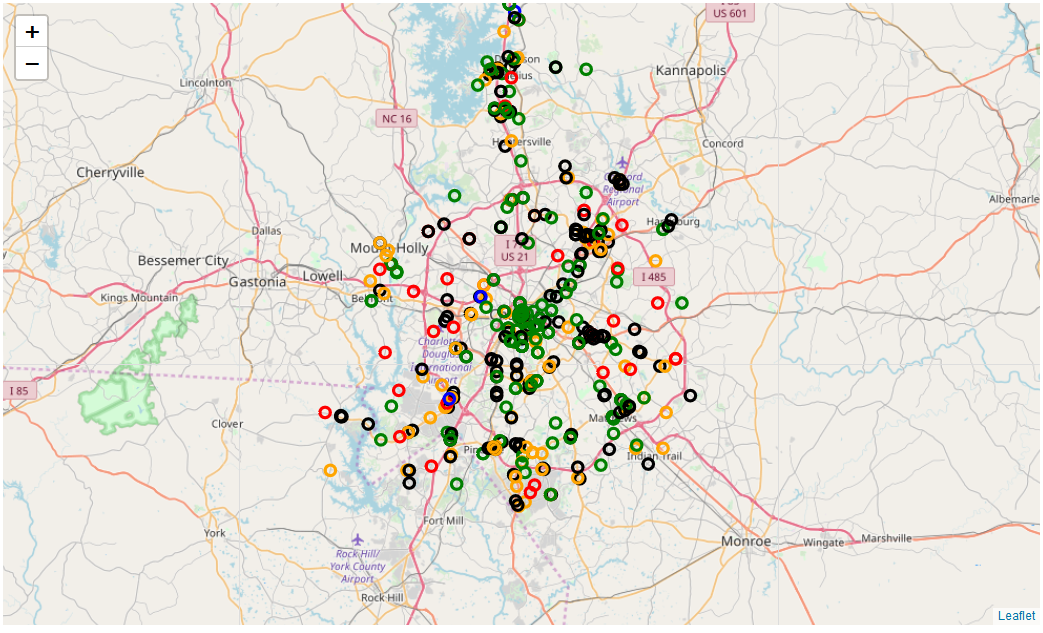

# one hot encoding

In [20]:
# one hot encoding
Charlotte_onehot = pd.get_dummies(venuedetails[['cat']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Charlotte_onehot['zip'] = venuedetails['zip'] 

# move neighborhood column to the first column
fixed_columns = [Charlotte_onehot.columns[-1]] + list(Charlotte_onehot.columns[:-1])
Charlotte_onehot = Charlotte_onehot[fixed_columns]

Charlotte_onehot.head()

,zip,Fire Station,Italian Restaurant,Medical Center,Mexican Restaurant,Park,Police Station
0,28214,0,0,0,1,0,0
1,28216,0,0,0,1,0,0
2,28208,0,0,0,1,0,0
3,28120,0,0,0,0,1,0
4,28120,0,1,0,0,0,0


# group by zip codes

In [21]:
zip_info =  Charlotte_onehot.groupby('zip').max()
zip_info.head()

,Fire Station,Italian Restaurant,Medical Center,Mexican Restaurant,Park,Police Station
zip,,,,,,
28012,1,1,0,1,1,1
28027,0,1,0,1,0,0
28031,1,1,0,1,1,0
28036,0,1,0,1,1,0
28075,0,0,0,1,1,0


# find zip codes with all required venues

In [22]:
qualified_zips = zip_info[(zip_info['Fire Station']==1) & (zip_info['Medical Center']==1) & (zip_info['Police Station']==1)]
qualified_zips.head()

,Fire Station,Italian Restaurant,Medical Center,Mexican Restaurant,Park,Police Station
zip,,,,,,
28208,1,1,1,1,1,1
28273,1,1,1,1,0,1


# zip code 28208 is the winner as it is the only zipcode with all items

# get all venues in zip code 28208

In [24]:
qualifiedvenue = venuedetails[venuedetails['zip'] == '28208']
qualifiedvenue.head()

,name,cat,zip,lat,lng
2,Salsarita's Fresh Cantina,Mexican Restaurant,28208,35.220233,-80.943746
28,Beauregards,Italian Restaurant,28208,35.243088,-80.889355
32,Charlotte Fire Station 13,Fire Station,28208,35.257657,-80.892165
33,Sbarro,Italian Restaurant,28208,35.257657,-80.892165
34,Flor Blanca,Mexican Restaurant,28208,35.245859,-80.898431


# find how many of each category zip code 28208 has

In [29]:
qualifiedvenue['cat'].value_counts()

Mexican Restaurant    7
Italian Restaurant    4
Park                  4
Fire Station          3
Police Station        3
Medical Center        1
Name: cat, dtype: int64

# map all venues in zip code 28208

In [27]:
map_winner = folium.Map(location=[latitude, longitude], zoom_start=12)
['Medical Center','Police Station','Fire Station','Mexican Restaurant','Italian Restaurant','Park']
# add markers to map
for lat, lng, cat in zip(qualifiedvenue['lat'], qualifiedvenue['lng'], qualifiedvenue['cat']):
    label = '{}'.format(cat)
    label = folium.Popup(label, parse_html=True)
    if cat == 'Medical Center':
        color ='blue'
    if cat == 'Police Station':
        color ='orange'
    if cat == 'Fire Station':
        color ='red'
    if cat == 'Mexican Restaurant':
        color ='black'
    if cat == 'Italian Restaurant':
        color='orange'
    if cat == 'Park':
        color ='green'
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color,
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_winner)  


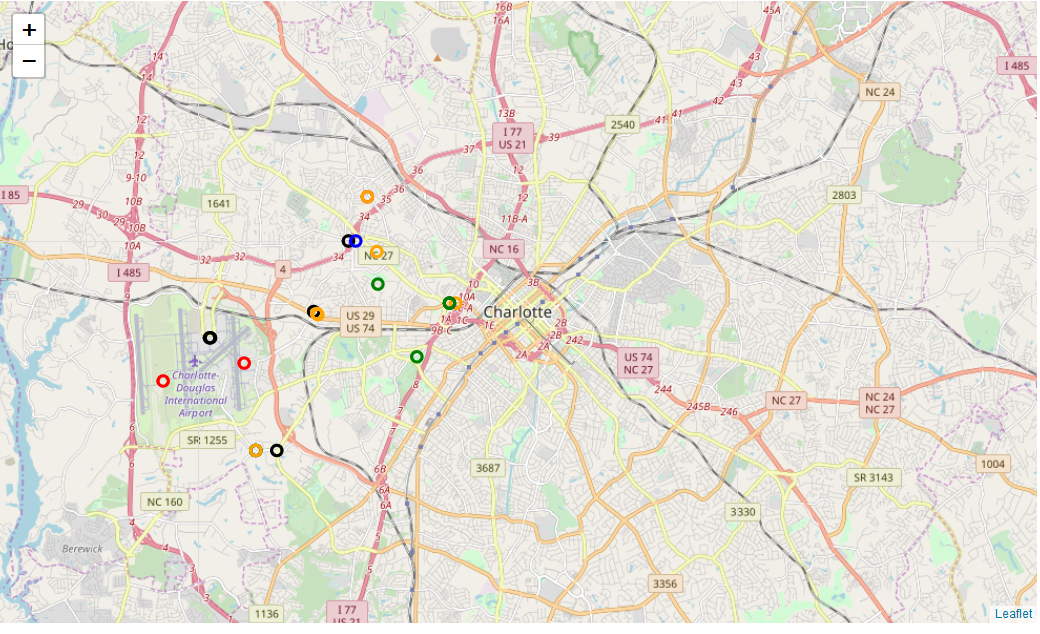